## **DISCLAIMER:**

*   To test the code, it is necessary to create a shortcut to the database files in 
the main folder of your Google Drive. 

  TrainingSquare380: https://drive.google.com/file/d/1H2P3fZh_ypdcV3WV5hICCG8_sSZnS2j9/view?usp=sharing

  Train_target: https://drive.google.com/file/d/1YttZCtJjHLCdN7J-SF6-bBY3B3sUr_Xm/view?usp=sharing

  TrainingSquare380val: https://drive.google.com/file/d/1-AItASE_gfxbiloI7Z5RtXWHwWfoQcqs/view?usp=sharing

  Validation_target: https://drive.google.com/file/d/1GiaekuFzNrmBdB_9Br4-q1xl3vinCvcR/view?usp=sharing

* 25 GB of RAM are needed to run the notebook on Colab. 

* It is necessary to create a shortcut to the weights of the best model we have got:
  https://drive.google.com/drive/folders/1HzZ_fvCVuQsu4y3OqE_6zsy5ACTXOMR4?usp=sharing

* The Dataset downloaded from Kaggle should be uploaded to Google Drive in the main folder with the name "*MaskDataset*"

## **Installing all the dependancies**




In [ ]:
!pip uninstall -y imgaug
!pip install imgaug
!pip install efficientnet
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git

In [3]:
%%capture
import os
import multiprocessing as mp
import gc
import numpy as np
np.random.seed(1234)
import pandas as pd
import cv2
from PIL import Image
import imgaug as ia
ia.seed(1234)
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.utils import shuffle as sklearn_shuffle

import tensorflow as tf
import face_detection
from matplotlib import pyplot
from matplotlib.patches import Rectangle

#from keras_vggface.vggface import VGGFace
from efficientnet.tfkeras import EfficientNetB4
#from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications import InceptionResNetV2

## **Data Loading & Preprocessing**



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH_TO_WEIGHTS = '/content/drive/My Drive/Keras3/classification_experiments/Best/cp_06.ckpt'

In [6]:
dataset_dir = os.path.join('/content/drive/My Drive', 'MaskDataset')
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
classes = ['0',         # NoMask
           '1',         # AllMask
           '2']         # SomeMask
n_classes = len(classes)
SEED=1234

In [6]:
X = np.load('/content/drive/My Drive/trainingsquare380.npy',allow_pickle = True)
X_val = np.load('/content/drive/My Drive/trainingsquare380val.npy',allow_pickle = True)
y = np.load('/content/drive/My Drive/train_target.npy',allow_pickle = True)
y_val = np.load('/content/drive/My Drive/validation_target.npy',allow_pickle = True)

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, 380, 380) 
else:
    input_shape = (380, 380, 3)

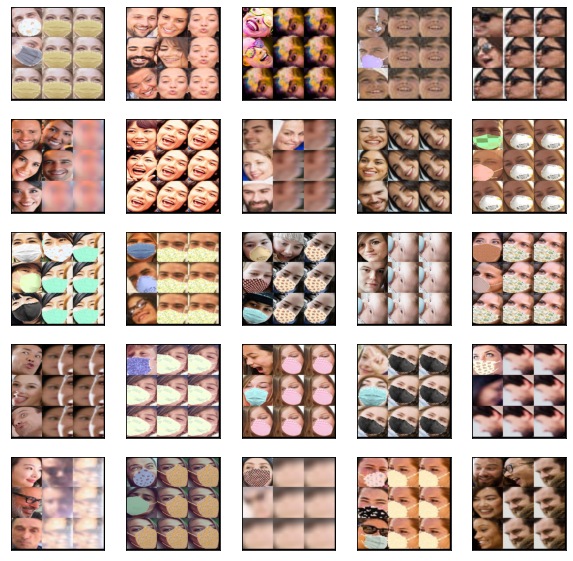

In [15]:
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])

plt.show()

In [16]:
def normalize_input(img):
    
    img = img.astype('float32')
    
    #Normalize by mean and std deviation
    #img = (img - img.mean()) / (img.std())

    #Normalize by scaling values in [0,+1]
    img /= 255

    if tf.keras.backend.image_data_format() == 'channels_first':
        img = np.rollaxis(img, 2, 0)
        
    return img
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 labels,
                 num_classes,
                 batch_size,
                 input_shape,
                 shuffle=False,
                 augment=[],
                 n_augmentations=1):
        
        self.input_shape = input_shape
            
        self.original_images = images
        self.original_labels = labels
        self.num_classes = num_classes
        
        self.batch_size = batch_size
        
        self.shuffle = shuffle
        self.augment = augment
        
        self.epoch = 0
        
        self.images = np.array(self.original_images)
        self.labels = np.array(self.original_labels)
        
        augmenters = []
        
        if 'fliplr' in self.augment:
            augmenters.append(iaa.Fliplr(.4))
            
        if 'crop' in self.augment:
            augmenters.append(iaa.Sometimes(0.4,
                                  iaa.CropAndPad(percent=(-0.15, -0.05),
                                                 pad_mode=ia.ALL,
                                                 pad_cval=(0, 255))))
        if 'blur' in self.augment:
            augmenters.append(iaa.GaussianBlur((0, 1.5)))
            
        if 'rotate' in self.augment:
            augmenters.append(iaa.Affine(rotate=(-10, 10)))
            
        self.seq = None
        self.n_augmentations = n_augmentations
        if len(augmenters) > 0 and self.n_augmentations > 0:
            self.seq = iaa.Sequential(augmenters, random_order=True)
            for _ in range(self.n_augmentations):
                self.images = np.append(self.images, self.original_images)\
                                .reshape(-1, *self.input_shape)
                self.labels = np.append(self.labels, self.original_labels)\
                                .reshape(-1, self.num_classes)
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        
        self.epoch += 1
        if self.shuffle == True:
            seed = self.batch_size * self.epoch
                        
            self.images, self.labels = sklearn_shuffle(self.images,
                                                       self.labels,
                                                       random_state=seed)
            
        self.n = self.__len__()
        gc.collect()
    def __len__(self):
        #in tensorflow docs ceil is used, but we found to be better using floor
        #return int(np.ceil(self.images.shape[0] / self.batch_size)) #add 4 total-black images (with class 0 = 'owl'!)
        return int(np.floor(self.images.shape[0] / self.batch_size)) #looses 4 images
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                              (step + 1) * self.batch_size]
        current_labels = self.labels[step * self.batch_size : \
                                    (step + 1) * self.batch_size]
        X, y = self.__generate_batch(current_images, current_labels, step)
        
        return X, y
    
    def __generate_batch(self, images, labels, step):
        X = np.zeros((self.batch_size, *self.input_shape))
        y = np.zeros((self.batch_size, self.num_classes))
        if self.seq is not None:
            if step >= self.n//self.n_augmentations:
                seq_det = self.seq.to_deterministic()
                images = seq_det.augment_images(images=images)
        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            y[idx] = labels[idx]
            
        return X, y

In [17]:
batch_size = 8
all_aug = ['fliplr',
           'crop',
           'blur',
           'rotate']
augment = all_aug
shuffle = True
onehot_y = tf.keras.utils.to_categorical(y)
onehot_y_val = tf.keras.utils.to_categorical(y_val)

In [18]:
train_generator = DataGenerator(X,
                                onehot_y,
                                num_classes=n_classes,
                                batch_size=batch_size,
                                input_shape=input_shape,
                                shuffle=shuffle)

In [19]:
validation_generator = DataGenerator(X_val,
                                     onehot_y_val,
                                     num_classes=n_classes,
                                     batch_size=batch_size,
                                     input_shape=input_shape)


## **Model**

In [8]:
learning_rate =0.35e-4
min_lr = 1e-6
dropout = .3
fc_size=300
freeze=0

base = EfficientNetB4(weights='noisy-student',
                          include_top=False,
                          input_shape=input_shape)

if freeze is None:
        freeze = len(base.layers)
        
for layer in base.layers[:freeze]:
  layer.trainable = False

out = base.output
out = tf.keras.layers.Flatten()(out)

out = tf.keras.layers.Dense(fc_size)(out)
out = tf.keras.layers.Activation('relu')(out)
out = tf.keras.layers.Dropout(dropout)(out)

out = tf.keras.layers.Dense(n_classes,
                            name='probabilities')(out)
out = tf.keras.layers.Activation('softmax',
                                  name='softmax',
                                  dtype='float32')(out)

model = tf.keras.models.Model(inputs=base.input, outputs=out)
model._name = base._name

model.load_weights(PATH_TO_WEIGHTS)

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
              metrics = ['accuracy'])
model.summary()

71680000/71678424 [==============================] - 6s 0us/step
Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
___________________

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()
exps_dir = os.path.join('/content/drive/My Drive/Keras3/', 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)
now = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'CNN'
exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []
# Model checkpoint
# ----------------

ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)
# Visualize Learning on Tensorboard
# ---------------------------------

tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min', 
                                              patience=7,
                                              verbose=1)
    callbacks.append(es_callback)

# ReduceLROnPlateau
# --------------

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode="min",
                                                 min_lr=0.00001,
                                                 factor=.5,
                                                 patience=2,
                                                 verbose=1)
callbacks.append(lr_callback)

## **Training**

In [ ]:
%%capture
training_enqueuer = tf.keras.utils.OrderedEnqueuer(train_generator,
                                                   use_multiprocessing=True,
                                                   shuffle=False)
training_enqueuer.start(workers=mp.cpu_count())
next(training_enqueuer.get())

In [ ]:
model.fit(train_generator,
          steps_per_epoch=train_generator.n,
          epochs=40,
          validation_data=validation_generator,
          validation_steps=validation_generator.n,
          verbose=1,
          callbacks=callbacks,
          use_multiprocessing=True,
          max_queue_size=2* mp.cpu_count(),
          workers=mp.cpu_count())

Epoch 1/40
589/589 [==============================] - 266s 452ms/step - loss: 0.0198 - accuracy: 0.9932 - val_loss: 0.4144 - val_accuracy: 0.9576
Epoch 2/40
589/589 [==============================] - 265s 450ms/step - loss: 0.0267 - accuracy: 0.9930 - val_loss: 0.4133 - val_accuracy: 0.9531
Epoch 3/40
589/589 [==============================] - 265s 450ms/step - loss: 0.0247 - accuracy: 0.9924 - val_loss: 0.4610 - val_accuracy: 0.9598
Epoch 4/40
589/589 [==============================] - 265s 451ms/step - loss: 0.0230 - accuracy: 0.9943 - val_loss: 0.4796 - val_accuracy: 0.9621
Epoch 5/40
589/589 [==============================] - 265s 451ms/step - loss: 0.0177 - accuracy: 0.9966 - val_loss: 0.4746 - val_accuracy: 0.9632
Epoch 6/40
589/589 [==============================] - 266s 451ms/step - loss: 0.0146 - accuracy: 0.9943 - val_loss: 0.4760 - val_accuracy: 0.9665
Epoch 7/40
589/589 [==============================] - 266s 452ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.4861 -

## **Test Data Preprocessing & Predictions**

In [24]:
test_dir = os.path.join(dataset_dir, 'test/')

X_test = [cv2.imread(test_dir + img) for img in os.listdir(test_dir)]
y_test = np.zeros(len(X_test))

In [25]:
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.2, nms_iou_threshold=.3)
im_empty = cv2.imread(training_dir + '/0/10340.jpg')
im_empty = cv2.cvtColor(im_empty, cv2.COLOR_BGR2RGB)
face_empty = detector.detect(im_empty)
print(face_empty)

Downloading: "http://folk.ntnu.no/haakohu/WIDERFace_DSFD_RES152.pth" to /root/.cache/torch/hub/checkpoints/WIDERFace_DSFD_RES152.pth



[[203.29738     56.67191    266.24954    149.11317      0.9999852 ]
 [544.0078      58.29521    611.75006    151.30202      0.99995494]
 [277.95465     64.95358    348.16388    164.87866      0.9998913 ]
 [ 17.763876   105.601524    88.03075    200.93016      0.99985385]
 [442.23837     79.76904    508.94485    184.18118      0.9998135 ]]


In [28]:
def squarer(file, result_list):
	file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)

	#Creating a dark square with NUMPY 

	shape = 380 
	grid = np.zeros((shape,shape,3),np.uint8)
	
	threshold = 19
	imgsz = int(shape/3)-1  # -1 in order to keep the image inside the grid
	lung=len(result_list)

  # Searching for elements with dimensions under threshold and removing them
	
	it=0
	while it <= (len(result_list)-1):

		if it < lung:    
			if int(result_list[it][2]-result_list[it][0]) < threshold or int(result_list[it][3]-result_list[it][1]) < threshold:
				result_list = np.delete(result_list,it,0)		
				lung = len(result_list)		
				it = it-1
		else: break 
		it = it+1

  # If the vector is empty we fill the image with the face_empty[0] face
   
	if len(result_list)==0:
		face0 = im_empty[int(face_empty[0][1]):int(face_empty[0][3]),int(face_empty[0][0]):int(face_empty[0][2])]
		face0 = cv2.resize(face0,(imgsz,imgsz))
		for i in range(3):
			for j in range(3):
				grid[j*imgsz:(j+1)*imgsz, i*imgsz:(i+1)*imgsz] = face0

  # Otherwise we crop every face from the original file and we copy it to the grid until all the faces are finished.
  # After that, if there is still space in the grid, we proceed by filling the remaining boxes with the last face found

	else:
		for i in range(3):
			for j in range(3):
				if (3*i+j)<len(result_list):
					newface = file[int(abs(result_list[i*3+j][1]-2)):int(abs(result_list[i*3+j][3]+2)), int(abs(result_list[i*3+j][0]-2)):int(abs(result_list[i*3+j][2]+2))]
					newface = cv2.resize(newface, (imgsz, imgsz))
					grid[j*imgsz:(j+1)*imgsz, i*imgsz:(i+1)*imgsz] = newface

				else:
					grid[j*imgsz:(j+1)*imgsz, i*imgsz:(i+1)*imgsz] = newface				
	return grid

In [29]:
squaretest=[]

for img in X_test: 
	#print(i)
	faces = detector.detect(img)
	squaretest.append(squarer(img, faces))

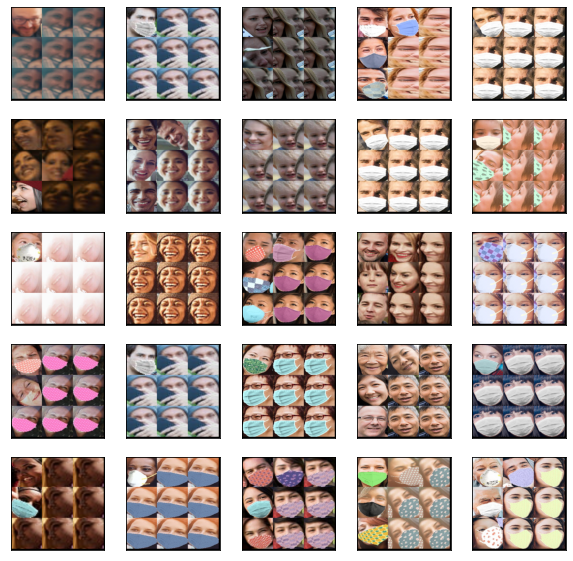

In [31]:
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, len(squaretest))
    plt.imshow(squaretest[idx])

plt.show()

In [32]:
class TestGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 labels,
                 num_classes,
                 batch_size,
                 input_shape,
                 augment=False):
        
        self.input_shape = input_shape
            
        self.original_images = images
        self.original_labels = labels

        self.num_classes = num_classes
        
        self.batch_size = batch_size
        
        self.epoch = 0
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.images = np.array(self.original_images)
        self.labels = np.array(self.original_labels)
        self.n = self.__len__()
        self.epoch += 1

    def __len__(self):
        return int(np.ceil(self.images.shape[0] / self.batch_size))
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                               (step + 1) * self.batch_size]

        current_labels = self.labels[step * self.batch_size : \
                                     (step + 1) * self.batch_size]

        X, y = self.__generate_batch(current_images, current_labels)
        return X, y
    
    def __generate_batch(self, images, labels):
        X = np.zeros((self.batch_size, *self.input_shape))
        y = np.zeros((self.batch_size, self.num_classes))
        
        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            y[idx] = labels[idx]
            
        return X, y

In [33]:
test_generator = TestGenerator(squaretest,
                                  tf.keras.utils.to_categorical(y_test),
                                  num_classes=n_classes,
                                  batch_size=1,
                                  input_shape=input_shape)

predictions = model.predict_generator(test_generator,
                                      verbose=1,
                                      use_multiprocessing=True,
                                      workers=mp.cpu_count())

predictions = np.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.
450/450 [==============================] - 11s 25ms/step


In [34]:
def create_csv(results, results_dir='/content/drive/My Drive', csv_fname='submission.csv'):
    
    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')
            
image_filenames = next(os.walk(test_dir))[2]

results = {}
for idx, image_name in enumerate(image_filenames):
    results[image_name] = predictions[idx]

csv_fname = 'effnetb4-submission-9688squareplus2.csv'           
create_csv(results, csv_fname=csv_fname)